# EDA

The purpose of this sheet is to explore the data, evaluate the shortcomings of our data, and identify the target feature.

I'll move through individual features to explore the data and check to make sure things make sense. This section will also give me a good sense for what types of features could be engineered in the next section.

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time

import plotly.express as px

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
pd.set_option('display.max_columns', None)

### Data Imports

In [3]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)

### Target Feature

The target feature for this analysis will be cost. Specifically the overall cost (Real Cost) of the project, which includes inflation and cost parity to account for the differences in location.

In [4]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.30,0.0,1.0,80.0,1432,0,18700,HKD,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006,5
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.00,0.0,2.0,80.0,1435,0,61.2,DM,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770,6
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0.0,6.0,100.0,1435,0,4780.525,CNY,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406,6
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.00,0.0,3.0,100.0,1435,0,2880,CNY,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296,2
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.00,0.0,1.0,80.0,1435,0,53,EUR,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.200,0.0,0.000,0.00,7.2,18.0,50.0,1000,1,100,EUR,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603,2
1029,US,Washington,1993,1999,0.0,4.700,1.0,4.700,0.00,0.0,2.0,95.0,1429,1,595.562775,USD,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592,6
1030,US,Washington,1994,1998,0.0,2.500,1.0,2.500,0.00,0.0,1.0,95.0,1429,1,243.809042,USD,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923,4
1031,US,Washington,1995,2001,0.0,10.700,0.7,7.490,3.22,0.0,5.0,95.0,1429,1,850.337905,USD,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801,6


### Start & End Year + Project Lengths

Let's look at the distributions of the start and end year to evaluate if there is a skew in our data. Projects that were completed long ago have been more difficult to find accurate information for and may be a source of error. Additionally, projects that will be completed in the future also present a similar difficulty and, I expect, a similar amount of error.

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_92704/2942270242.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_92704/2942270242.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


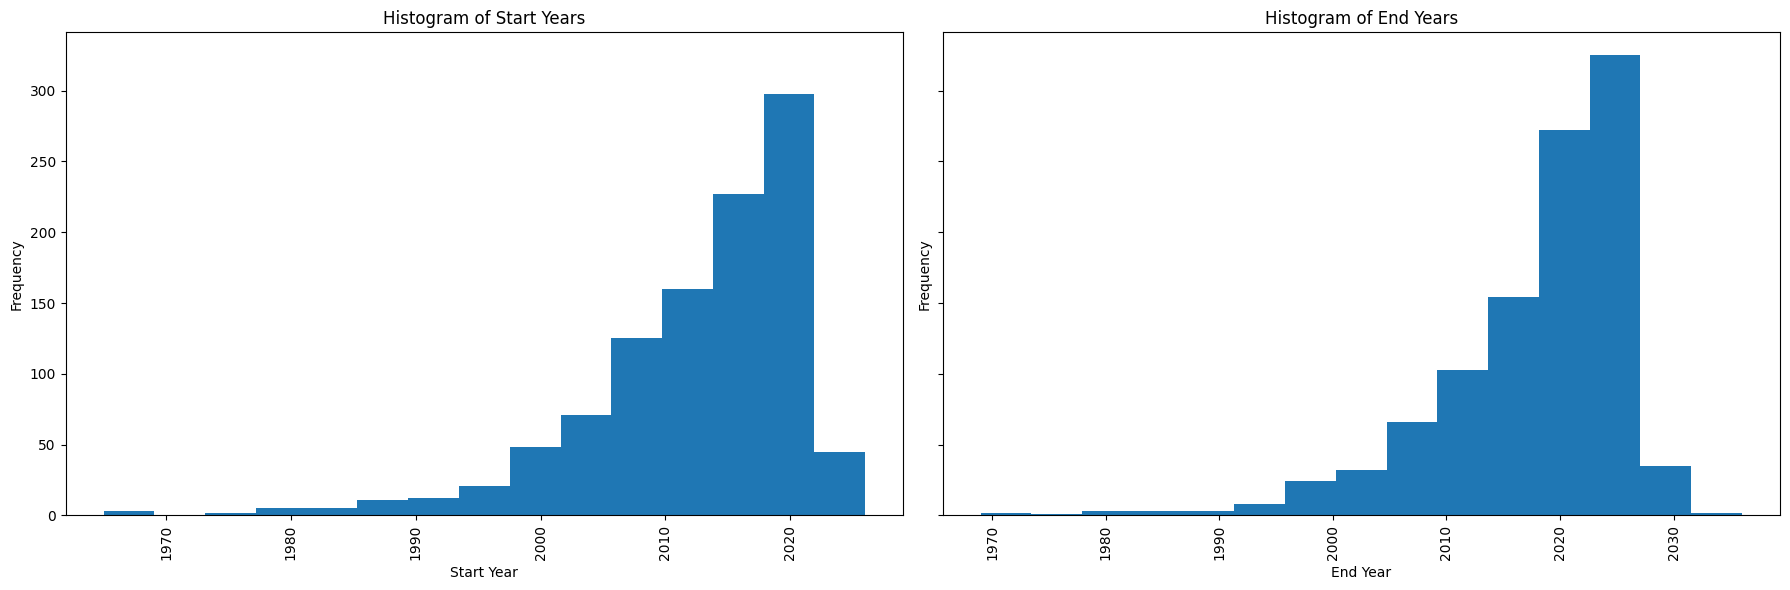

In [5]:
n_bins = 15

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18, 6))

plt.subplots_adjust(wspace=.1)

axs[0].hist(df['start_year'], bins=n_bins)
axs[1].hist(df['end_year'], bins=n_bins)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

axs[0].set_xlabel('Start Year')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Start Years')

axs[1].set_xlabel('End Year')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of End Years')

plt.show()

Both distributions shown above are relatively normal. It's difficult to identify a skew, however both plots have a long tail towards the left. This is logical as projects are less likely to be planned 20 years into the future.

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_92704/4145860887.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


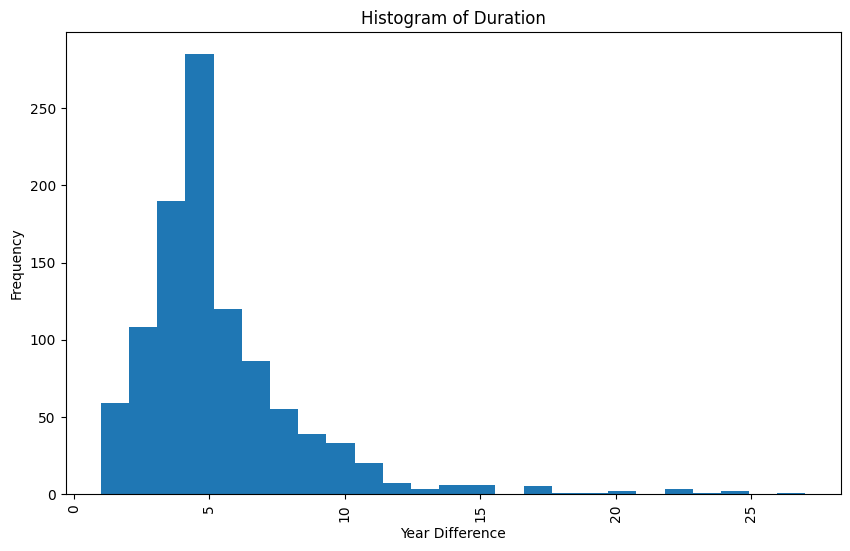

In [6]:
n_bins = 25

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1)

axs.hist(df['duration'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.set_xlabel('Year Difference')
axs.set_ylabel('Frequency')
axs.set_title('Histogram of Duration')

plt.show()

This distribution is much more normal than the previous two plots. This is a good sign, however it's important to remember that many of our projects have not yet been completed and the above dates are projections. It's possible that delays will occur and the distribution will become (accurately) less normal than displayed above.

### Length Components

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_92704/2254531849.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


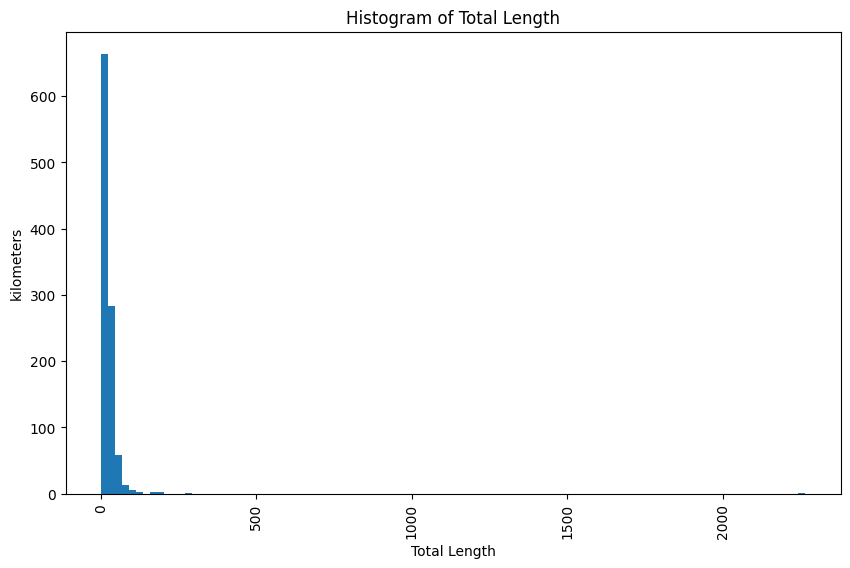

In [7]:
n_bins = 100

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1)  # Adjust the horizontal space between subplots

axs.hist(df['length'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Total Length')

plt.show()

From the above histogram we see that, generally, the total length component is relatively tightly grouped with a single outlier far and away longer than the other projects. Let's remove this outlier from this histogram and then replot

In [8]:
total_length_hist = df[df['length'] < 2000]

In [9]:
total_length_hist

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.30,0.0,1.0,80.0,1432,0,18700,HKD,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006,5
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.00,0.0,2.0,80.0,1435,0,61.2,DM,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770,6
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0.0,6.0,100.0,1435,0,4780.525,CNY,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406,6
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.00,0.0,3.0,100.0,1435,0,2880,CNY,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296,2
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.00,0.0,1.0,80.0,1435,0,53,EUR,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.200,0.0,0.000,0.00,7.2,18.0,50.0,1000,1,100,EUR,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603,2
1029,US,Washington,1993,1999,0.0,4.700,1.0,4.700,0.00,0.0,2.0,95.0,1429,1,595.562775,USD,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592,6
1030,US,Washington,1994,1998,0.0,2.500,1.0,2.500,0.00,0.0,1.0,95.0,1429,1,243.809042,USD,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923,4
1031,US,Washington,1995,2001,0.0,10.700,0.7,7.490,3.22,0.0,5.0,95.0,1429,1,850.337905,USD,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801,6


/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_92704/1385921891.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


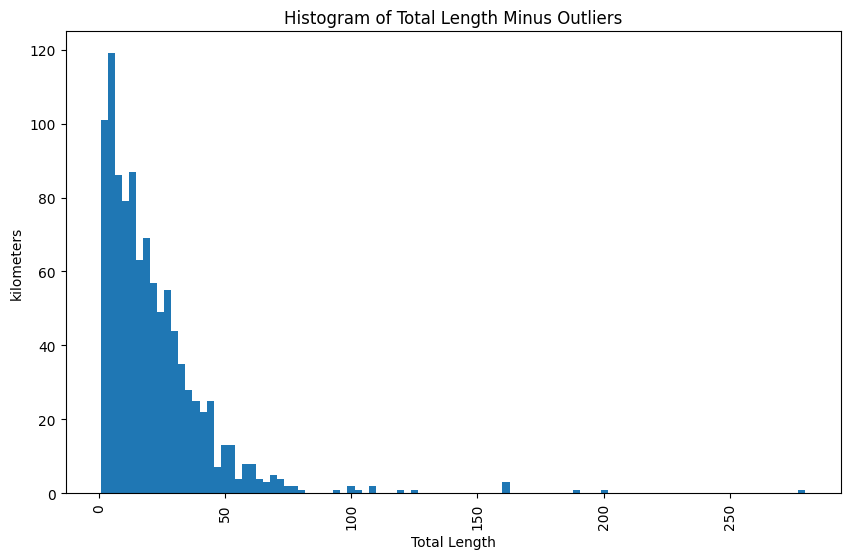

In [10]:
n_bins = 100

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1)
axs.hist(total_length_hist['length'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Total Length Minus Outliers')

plt.show()

Now we can see more clearly that the projects are all fairly tightly grouped between 0 and 50km. This is a reasonable grouping as it's more likely that a project phase will be broken into smaller components and executed individually in phases.

Let's do the same for the tunnel component

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_92704/572999720.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


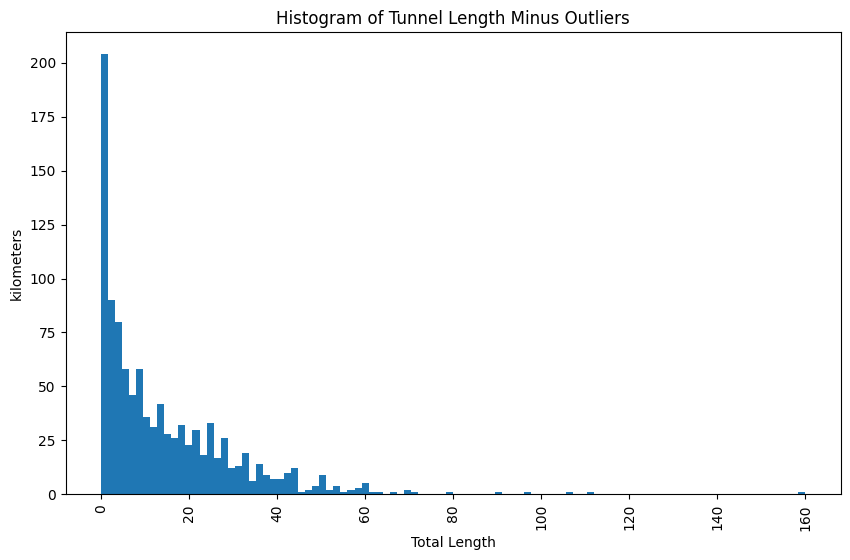

In [11]:
n_bins = 100

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1) 
axs.hist(total_length_hist['tunnel'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Tunnel Length Minus Outliers')

plt.show()

This time we'll need to look at only the projects that have a tunneling component

In [12]:
tunnel_length_hist = df[df['tunnel'] > 0]

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_92704/572999720.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


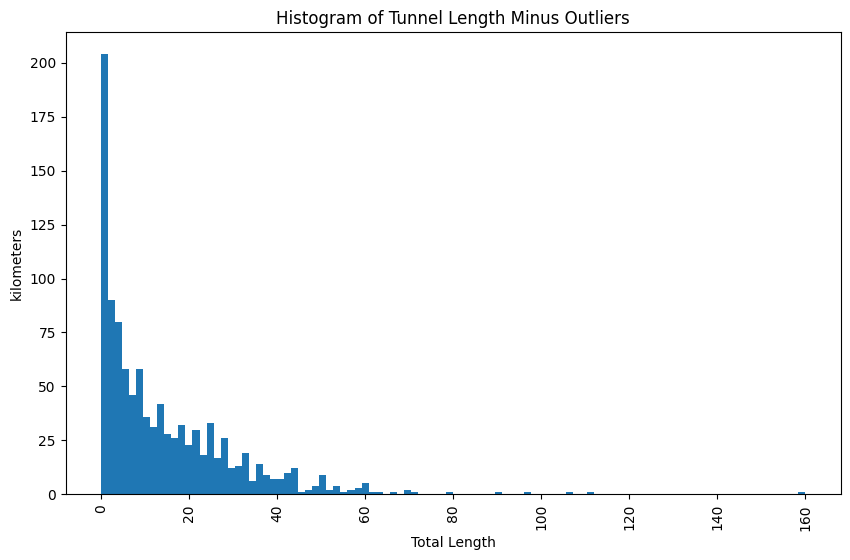

In [13]:
n_bins = 100

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1) 
axs.hist(total_length_hist['tunnel'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Tunnel Length Minus Outliers')

plt.show()

There is not much observable difference between the last two plots, however they are both reasonable distributions given the real life implications of tunneling

### Cost Components

Before we continue to analyze the data in subsequent sheets, I want to make sure that the cost components have a reasonable distribution and that there aren't any significant outliers. This feature was difficult to evaluate previously as the dollar value of a project can vary so widely from project to project.

For this section, we'll use the real cost per km as this represents the best normalized version of the target variable.

In [14]:
df['cost_km_2021']

0       3673.100006
1        207.402770
2        340.371406
3        200.443296
4         79.374570
           ...     
1028      25.362603
1029     238.217592
1030     175.925923
1031     140.765801
1032      54.920907
Name: cost_km_2021, Length: 1033, dtype: float64

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_92704/107176119.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


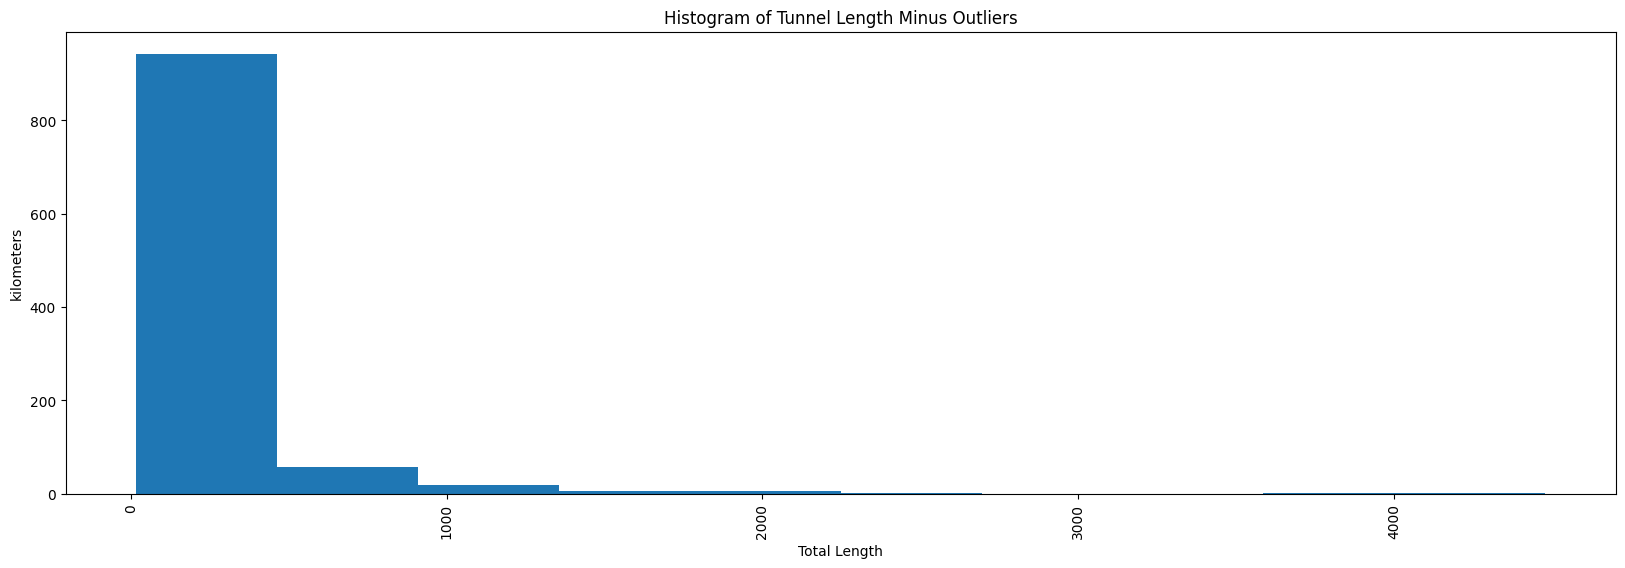

In [15]:
n_bins = 10

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots

axs.hist(df['cost_km_2021'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.set_xlabel('Total Length')
axs.set_ylabel('kilometers')
axs.set_title('Histogram of Tunnel Length Minus Outliers')

plt.show()

#### Upper-End Outliers

In [16]:
df['cost_km_2021'].astype('int')

0       3673
1        207
2        340
3        200
4         79
        ... 
1028      25
1029     238
1030     175
1031     140
1032      54
Name: cost_km_2021, Length: 1033, dtype: int64

In [17]:
df[df['cost_km_2021'] >1000].sort_values(by='cost_km_2021',ascending=False)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration
866,US,New York,2007,2022,1.0,2.8,1.00,2.800,0.000,0.0,1.0,70.0,1435,0,11000,USD,2015,1.000000,11000.000000,3928.571429,0.0,0.00,1.0,1.14,12540.000000,4478.571429,15
0,HK,Hong Kong,2000,2005,0.0,1.3,0.00,0.000,1.300,0.0,1.0,80.0,1432,0,18700,HKD,2005,0.183704,3435.273387,2642.517990,0.0,0.00,0.0,1.39,4775.030008,3673.100006,5
778,US,New York,2019,2029,0.0,2.6,1.00,2.600,0.000,0.0,3.0,70.0,1435,0,6949,USD,2024,1.000000,6949.000000,2672.692308,0.0,0.00,1.0,1.00,6949.000000,2672.692308,10
912,TW,Taipei,1988,2012,0.0,93.9,0.65,61.035,32.865,0.0,92.0,90.0,1880,0,557286,TWD,2000,0.274728,153102.085700,1630.480146,0.0,0.00,0.0,1.57,240370.274600,2559.853829,24
402,TW,Taipei,2002,2013,0.0,6.5,1.00,6.500,0.000,0.0,7.0,90.0,1435,0,39000,TWD,2007,0.265983,10373.334770,1595.897656,0.0,0.00,0.0,1.31,13589.068540,2090.625930,11
608,US,New York,2007,2016,0.0,2.7,1.00,2.700,0.000,0.0,3.0,70.0,1435,0,4601,USD,2011,1.000000,4601.000000,1704.074074,0.0,0.00,1.0,1.20,5521.200000,2044.888889,9
463,HK,Hong Kong,2023,2029,0.0,1.8,1.00,1.800,0.000,0.0,1.0,80.0,1435,0,18700,HKD,2016,0.168569,3152.240223,1751.244568,0.0,0.00,0.0,1.13,3562.031452,1978.906362,6
378,US,New York,2007,2014,0.0,1.6,1.00,1.600,0.000,0.0,1.0,70.0,1435,0,2400,USD,2010,1.000000,2400.000000,1500.000000,0.0,0.00,1.0,1.24,2976.000000,1860.000000,7
875,TW,Kaohsiung,2001,2008,0.0,43.0,0.74,31.820,11.180,0.0,38.0,90.0,1435,0,181300,TWD,2004,0.301351,54634.881000,1270.578628,0.0,0.00,0.0,1.43,78127.879820,1816.927438,7
842,US,New York,2019,2026,1.0,5.3,1.00,5.300,0.000,0.0,0.0,70.0,1435,1,9500,USD,2023,1.000000,9500.000000,1792.452830,0.0,0.00,1.0,1.00,9500.000000,1792.452830,7


There's several projects that are outliers, at least at first glance. I'll make note and review these data points in section 06. The outliers don't seem to be erroneous and so I'll leave them in for the time being.

#### Lower-End Outliers

In [18]:
df[df['cost_km_2021'] <15].sort_values(ascending = True, by = 'cost_km_2021')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration


All of the low end data points are from Beijing. Again, I'll make note and address these in section 06.

### Economic & Monetary Indicators

Within the dataset, the real cost is a calculated value that is a function of the stated cost of a project multiplied by two factors: PPP rate (purchasing power parity & inflation rate). For the sake of brevity, I've outlined the purpose of these factors in the introduction section. However, since these factors determine the magnitude of the target feature, it's important that we check both to ensure there aren't any erroneous values in the dataset.

##### PPP Rate

For this section, I intend to evaluate the distribution of the PPP rate and then validate the factor provided in the dataset.

In [19]:
df.sort_values(by='ppp_rate', ascending= False)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration
210,TR,Izmir,1995,2000,0.0,11.60,0.29,3.3640,8.236,0.00,10.0,70.0,1435,0,900,TRY,1998,7.759818,6983.836299,602.054853,11.6,3.4,0.0,1.66,11593.168260,999.411057,5
30,CN,Beijing,1965,1969,0.0,23.60,1.00,23.6000,0.000,0.00,17.0,100.0,1435,0,700,CNY,1965,6.666667,4666.666667,197.740113,0.0,0.0,0.0,8.60,40133.333330,1700.564972,4
910,KW,Kuwait City,2020,2025,0.0,160.00,0.35,56.0000,104.000,0.00,68.0,60.0,1435,1,6000,KWD,2020,6.233623,37401.739320,233.760871,0.0,0.0,0.0,1.05,39271.826280,245.448914,5
800,BH,Bahrain,2020,2025,1.0,72.70,0.00,0.0000,72.700,0.00,18.0,65.0,1435,1,1500,BD,2010,6.016569,9024.853061,124.138281,0.0,0.0,0.0,1.24,11190.817800,153.931469,5
23,EG,Cairo,1982,1999,0.0,42.86,0.11,4.7146,0.000,38.16,35.0,80.0,1435,1,948.2775,LE,1982,5.882353,5578.102941,130.147059,0.0,0.0,0.0,2.81,15674.469260,365.713235,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,VN,Hanoi,2010,2013,0.0,12.50,0.32,4.0000,8.500,0.00,12.0,80.0,1435,0,36000000,VND,2016,0.000137,4920.982154,393.678572,0.0,0.0,0.0,1.13,5560.709834,444.856787,3
390,VN,Hanoi,2011,2020,0.0,11.50,0.74,8.5100,2.990,0.00,12.0,80.0,1435,0,19555000,VND,2015,0.000135,2637.771256,229.371414,0.0,0.0,0.0,1.14,3007.059232,261.483411,9
376,IR,Tehran,2012,2014,0.0,12.00,1.00,12.0000,0.000,0.00,11.0,80.0,1435,0,20000000,IRR,2013,0.000118,2351.876833,195.989736,0.0,0.0,0.0,1.16,2728.177127,227.348094,2
725,IR,Tehran,2015,2017,0.0,27.00,1.00,27.0000,0.000,0.00,25.0,80.0,1435,0,90000000,IRR,2017,0.000077,6890.587843,255.206957,0.0,0.0,0.0,1.11,7648.552506,283.279722,2


In [20]:
df[df['ppp_rate'] > 4]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration
23,EG,Cairo,1982,1999,0.0,42.86,0.11,4.7146,0.000,38.16,35.0,80.0,1435,1,948.2775,LE,1982,5.882353,5578.102941,130.147059,0.0,0.0,0.0,2.81,15674.469260,365.713235,17
30,CN,Beijing,1965,1969,0.0,23.60,1.00,23.6000,0.000,0.00,17.0,100.0,1435,0,700,CNY,1965,6.666667,4666.666667,197.740113,0.0,0.0,0.0,8.60,40133.333330,1700.564972,4
210,TR,Izmir,1995,2000,0.0,11.60,0.29,3.3640,8.236,0.00,10.0,70.0,1435,0,900,TRY,1998,7.759818,6983.836299,602.054853,11.6,3.4,0.0,1.66,11593.168260,999.411057,5
358,BH,Bahrain,2018,2024,1.0,28.60,0.00,0.0000,28.600,0.00,20.0,65.0,1435,1,453,BD,2019,5.333697,2416.164956,84.481292,0.0,0.0,0.0,1.06,2561.134853,89.550170,6
800,BH,Bahrain,2020,2025,1.0,72.70,0.00,0.0000,72.700,0.00,18.0,65.0,1435,1,1500,BD,2010,6.016569,9024.853061,124.138281,0.0,0.0,0.0,1.24,11190.817800,153.931469,5
910,KW,Kuwait City,2020,2025,0.0,160.00,0.35,56.0000,104.000,0.00,68.0,60.0,1435,1,6000,KWD,2020,6.233623,37401.739320,233.760871,0.0,0.0,0.0,1.05,39271.826280,245.448914,5


As we see, there is a subset of the data where the PPP_rate is signficantly larger than 3. Given the countries involved, this is reasonable but I'd like to verify some of these values independently.

- Bahrain, index 358 & index 800: According to the data, in the year 2018, Bahrain had a PPP_rate of .2 (factor of 5). This data matches up with the UN PPP conversion factor, GDP (LCU per international $)
- Uzbekistan, index 110 & index 129: According to data provided by the UN, the stated rate of 5 is reasonable

One other important thing to note is that many countries that are listed in the dataset are transacting in currencies outside of their local currency. This changes the calculation of the real cost and, since I'm not an economist, is likely a blind spot/source of error for me.

All I can hope to do is evaluate the data with a model and see if the results are reasonable.

****After modelling, this was a source of error. My solution was to convert all the currencies into their native currency, which I believe resolved the unmatched PPP rate and country currency issue****

##### Inflation Index

In [21]:
df.sort_values(by='inflation_index', ascending= False)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,cost,currency,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021,duration
30,CN,Beijing,1965,1969,0.0,23.60,1.00,23.600,0.000,0.0,17.0,100.0,1435,0,700,CNY,1965,6.666667,4666.666667,197.740113,0.0,0.0,0.0,8.60,40133.333330,1700.564972,4
50,DE,Munich,1965,1971,1.0,11.40,0.36,4.104,7.296,0.0,5.0,80.0,1435,1,459,DM,1968,0.764430,350.873170,30.778348,0.0,0.0,0.0,7.79,2733.301992,239.763333,6
1,DE,Berlin,1968,1974,0.0,1.50,1.00,1.500,0.000,0.0,2.0,80.0,1435,0,61.2,DM,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.69,311.104154,207.402770,6
663,HK,Hong Kong,1975,1980,0.0,15.60,0.82,12.792,2.800,0.0,15.0,80.0,1432,0,5637,HKD,1977,0.251256,1416.331658,90.790491,0.0,0.0,0.0,4.47,6331.002513,405.833494,5
51,US,Philadelphia,1976,1984,1.0,2.90,0.69,2.001,0.899,0.0,1.0,70.0,1435,1,330,USD,1980,1.000000,330.000000,113.793103,0.0,0.0,1.0,3.29,1085.700000,374.379310,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,CN,Qingdao,2021,2026,0.0,18.80,1.00,18.800,0.000,0.0,9.0,80.0,1435,0,11492,CNY,2021,0.238815,2744.461761,145.982009,0.0,0.0,0.0,1.00,2744.461761,145.982009,5
886,EG,Cairo,2019,2023,0.0,98.50,0.00,0.000,98.500,0.0,35.0,80.0,1435,0,135000,EGP,2022,0.213574,28832.430380,292.715029,0.0,0.0,0.0,1.00,28832.430380,292.715029,4
429,CN,Shenzhen,2022,2027,0.0,8.43,1.00,8.430,0.000,0.0,5.0,80.0,1435,1,11206,CNY,2021,0.238815,2676.160677,317.456782,0.0,0.0,0.0,1.00,2676.160677,317.456782,5
721,CN,Shenzhen,2021,2026,1.0,39.40,1.00,39.400,0.000,0.0,6.0,120.0,1435,1,23620,CNY,2021,0.238815,5640.809850,143.167763,0.0,0.0,0.0,1.00,5640.809850,143.167763,5


This is another section I'll have to revisit if the results are not reasonable. I don't believe plotting the data in a histogram would be beneficial as the inflation index is an abstracted financial instrument.

### Section Conclusion

Within this section I evaluated the data with the intent to verify that the dataset was representative. The purpose of this task was to improve the model's ability to predict unseen data and creating more normally distributed features is a good first step. Many of these tasks will be expanded upon as I get further into the modelling process in future sheets.

### Dataframe Export

In [22]:
with open('pickles/df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [23]:
df.shape

(1033, 27)